In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import torch
from my_utils_v2 import *
from PIL import Image

In [2]:
model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/Smoothness_1_epochs/epoch_15/epoch_15.pth'
model,device=Utils_v2.load_model(model_path) #Write this code

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [22]:
dapi_round0 = '/fs5/p_masi/rudravg/MxIF_Vxm_Registered/GCA020TIB_TISSUE01_v1/Unregistered/GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_00.tif'
dapi_round_last = '/fs5/p_masi/rudravg/MxIF_Vxm_Registered/GCA020TIB_TISSUE01_v1/Unregistered/GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_18.tif'

block_size = 1024

dapi_round0=np.array(Image.open(dapi_round0)) / 255.
dapi_round_last=np.array(Image.open(dapi_round_last)) /255.
original_height, original_width = dapi_round0.shape

pad_size0 = block_size - dapi_round0.shape[0] % block_size
pad_size1 = block_size - dapi_round0.shape[1] % block_size

# Pad the images
dapi_round0 = np.pad(dapi_round0, ((0, pad_size0), (0, pad_size1)))
dapi_round_last = np.pad(dapi_round_last, ((0, pad_size0), (0, pad_size1)))

In [4]:
L2_norm=Utils_v2.L2_norm_mask(dapi_round0,dapi_round_last,model,device)

In [5]:
L2_norm

array([[1.5342386 , 1.3709178 , 1.2141435 , ..., 1.911808  , 1.6939518 ,
        1.2371798 ],
       [1.1652377 , 1.9574851 , 4.6629405 , ..., 1.5189575 , 0.28298312,
        1.3080481 ],
       [1.2083926 , 5.0041184 , 5.5064144 , ..., 1.5899092 , 0.9404468 ,
        1.6530527 ],
       ...,
       [0.9319148 , 1.040462  , 1.6003175 , ..., 4.1324906 , 3.4498503 ,
        1.5002921 ],
       [0.6689983 , 0.32484373, 0.563833  , ..., 3.129836  , 0.8739026 ,
        1.1647363 ],
       [0.64991283, 0.778729  , 0.9586322 , ..., 1.2091571 , 0.8721157 ,
        0.87921244]], dtype=float32)

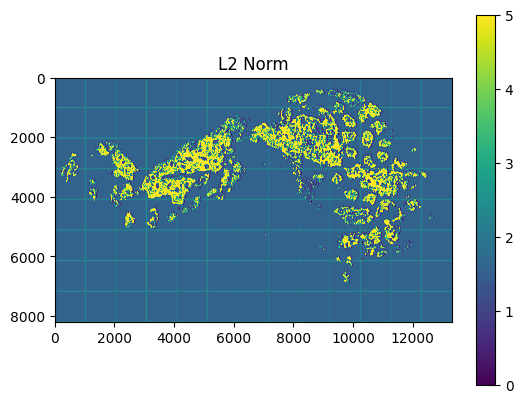

In [40]:
plt.figure()

# Display the L2 norm
plt.imshow(L2_norm, cmap='viridis',vmin=0,vmax=5)

# Add a colorbar
plt.colorbar()

# Set the title
plt.title('L2 Norm')
# Show the plot
plt.show()

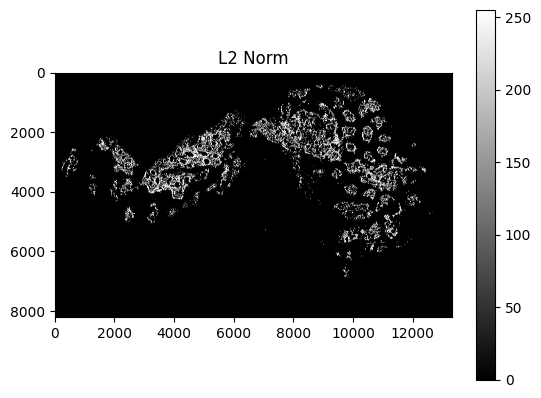

In [46]:
mask = L2_norm > 10

# Convert the mask to an image with black (0) and white (255) pixels
mask_image = (mask * 255).astype(np.uint8)
plt.figure()

# Display the L2 norm
plt.imshow(mask_image,cmap='gray')

# Add a colorbar
plt.colorbar()

# Set the title
plt.title('L2 Norm')
# Show the plot
plt.show()

In [47]:
#Save the mask
mask_path = '/fs5/p_masi/rudravg/MxIF_Vxm_Registered/GCA020TIB_TISSUE01_v1/Unregistered/Mask_L2.tif'
mask_image = mask_image[:original_height, :original_width]
Image.fromarray(mask_image).save(mask_path)


In [49]:
import os
from PIL import Image
from tqdm import tqdm

# Define the directory path
dir_path = '/fs5/p_masi/rudravg/MxIF_Vxm_Registered/GCA020TIB_TISSUE01/L2_masked_AF_Removed'

# Get a list of all files in the directory
file_names = os.listdir(dir_path)

# Loop over all files
for file_name in tqdm(file_names):
    # Construct the full file path
    file_path = os.path.join(dir_path, file_name)

    # Open the image file
    image = Image.open(file_path)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Apply the mask
    image_array[mask_image == 255] = 0

    # Convert the array back to an image
    image = Image.fromarray(image_array)

    # Save the image
    image.save(file_path)

100%|██████████| 31/31 [00:41<00:00,  1.33s/it]
